In [1]:
"""
Post-processing analysis script for cortical layer intensity data.
This code processes and visualizes results from quality_control_native_surface_slurm.py

#use conda env: niwrap3912
"""
import os
import yaspy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde

base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
LAYER_TYPE = 'inf'
RESOLUTION = '120um'  # 120um or 240um
data_base_path = f"/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_{RESOLUTION}_max_960um_dist_method0"



In [ ]:
''' THIS IS FOR MYELO ARCHITECTURE PARCELLATION*** 090225 -DJ
#I mean the paper says that the granular layer is included in the infragranular layer (Zeng et al., 2024; 7T ex vivo data segmentation...)
#this sections can only be run after "run_myelo_parcellation.ipynb"

#A whole-brain 3D myeloarchitectonic atlas: Mapping the Vogt-Vogt legacy to the cortical surface
import os
import nibabel as nib

#fsaverage  ico6 *
base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
#subject_name = "I45_new_confidence"
niu_folder = "niu_parcellation_output"
hemisphere = "lh"
layer = "inf"
#for nieuwenhuys
#file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"
#for Baillarger
parcel_type = "nieuwenhuys" #or "baillarger"
if parcel_type.lower() == "nieuwenhuys":
    file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"
    title_name = "Nieuwenhuys parcellation"
elif parcel_type.lower() == "baillarger":   
    file_name = f"{subject_name}_{hemisphere}_baillarger_parcellation.label.gii"
    title_name = "Baillarger parcellation"
#surface file to plot this
surface_file = surface_file = f"{base_path}/{subject_name}/{hemisphere}.{layer}.32k_fs_LR.surf.gii"
#read the file     

# Read the annotation file
niu_file = nib.load(os.path.join(base_path, subject_name, niu_folder, file_name))
label_data = niu_file.darrays[0].data
label_color = niu_file.labeltable
# Extract just the color values from the labels
color_values = [label.rgba for label in label_color.labels]
from matplotlib.colors import ListedColormap
orig_cmap = ListedColormap(color_values)
orig_cmap = 'jet'
#so the size is 164k and I need to dwonsample to 32k
plotter = yaspy.Plotter(surface_file, hemi=hemisphere)
plotter.overlay(label_data, cmap=orig_cmap)

#make colormap using the colorvales


# Generate multi-view montage
views = ['lateral', 'medial']
screenshots = [plotter.screenshot(view) for view in views]
montage = yaspy.montage(screenshots, pad=8)
# Create and style figure
fig, ax = plt.subplots(figsize=(6,4))
for spine in ax.spines.values():
    spine.set_visible(False)
plt.imshow(montage,cmap=orig_cmap)
plt.axis('off')


norm = plt.Normalize(vmin=np.min(label_data), vmax=np.max(label_data))
sm = plt.cm.ScalarMappable(cmap=orig_cmap, norm=norm)
cax = ax.inset_axes((0.8, 0, 0.18, 0.04))
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal", extend='both')
cbar.ax.tick_params(labelsize="x-small")
plt.title(f"{title_name}, subject: {subject_name}", fontsize="medium")
'''

' THIS IS FOR MYELO ARCHITECTURE PARCELLATION*** 090225 -DJ\n#I mean the paper says that the granular layer is included in the infragranular layer (Zeng et al., 2024; 7T ex vivo data segmentation...)\n#this sections can only be run after "run_myelo_parcellation.ipynb"\n\n#A whole-brain 3D myeloarchitectonic atlas: Mapping the Vogt-Vogt legacy to the cortical surface\nimport os\nimport nibabel as nib\n\n#fsaverage  ico6 *\nbase_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"\n#subject_name = "I45_new_confidence"\nniu_folder = "niu_parcellation_output"\nhemisphere = "lh"\nlayer = "inf"\n#for nieuwenhuys\n#file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"\n#for Baillarger\nparcel_type = "nieuwenhuys" #or "baillarger"\nif parcel_type.lower() == "nieuwenhuys":\n    file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"\n    title_name = "Nieuwenhuys parcellation"\nelif parcel_type.lower() == "baillarger":   \n    file_name = f"{subj

In [3]:
# Analysis for left and right hemispheres
from scipy.stats import zscore

# Initialize data containers
all_data = {
    'lh': {'intensity_data': [], 'subject_names': []},
    'rh': {'intensity_data': [], 'subject_names': []}
}

# Analysis parameters
layer = 'inf'
data_type = "diff"
do_zscore = True

# Extract postfix from data base path
postfix = data_base_path.split('_')[-1]  # This grabs 120um

# Process ex-vivo subjects
for subjects in os.listdir(base_path):
    if subjects:
        for hemispheres in ['lh', 'rh']:
            intensity_file_path = os.path.join(
                data_base_path, 
                subjects, 
                f"{hemispheres}/{LAYER_TYPE}_{RESOLUTION}_method0_manual_raw_intensity.npz"
            )

            if os.path.exists(intensity_file_path):
                # Load intensity data
                data = np.load(intensity_file_path, allow_pickle=True)
                dist_array = data['dist_array']
                
                # Process data based on type
                tmp_dat = data['all_values']
                if data_type == 'diff':
                    tmp_dat = np.diff(tmp_dat, axis=0)
                if do_zscore:
                    tmp_dat = zscore(tmp_dat, axis=0)
                
                # Store data by hemisphere
                clean_subject_name = subjects.replace('_new_confidence', '')
                print(f"Loaded ex-vivo subject: {clean_subject_name}, hemisphere: {hemispheres}")
                
                all_data[hemispheres]['intensity_data'].append(tmp_dat)
                all_data[hemispheres]['subject_names'].append(clean_subject_name)

# Load BigBrain data
bigbrain_base_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii'

for hemi in ['lh', 'rh']:
    bb_file_path = os.path.join(bigbrain_base_path, f'bigbrain_{hemi}_layer3_{RESOLUTION}_method0_manual_raw_intensity.npz')
    
    if os.path.exists(bb_file_path):
        bb_data = np.load(bb_file_path)['all_values']
        
        # Apply same processing as ex-vivo data
        if data_type == 'diff':
            bb_data = np.diff(bb_data, axis=0)
        if do_zscore:
            bb_data = zscore(bb_data, axis=0)
        
        all_data[hemi]['intensity_data'].append(bb_data)
        all_data[hemi]['subject_names'].append('bigbrain')
        print(f"Loaded BigBrain data for hemisphere: {hemi}")

# Find zero index for distance array (using the last loaded dist_array)
zero_indices = np.where(dist_array == 0)[0]
if len(zero_indices) > 0:
    zero_index = zero_indices[0]
else:
    # If no exact zero, find the closest value to zero
    zero_index = np.argmin(np.abs(dist_array))
    print(f"No exact zero found, using closest value at index {zero_index} with value {dist_array[zero_index]}")

# Create convenient access variables for backward compatibility
lh_intensity_data_uncut = all_data['lh']['intensity_data']
rh_intensity_data_uncut = all_data['rh']['intensity_data']
lh_subject_names = all_data['lh']['subject_names']
rh_subject_names = all_data['rh']['subject_names']

# Print summary
print(f"\nData loading summary:")
print(f"Left hemisphere: {len(lh_subject_names)} subjects - {lh_subject_names}")
print(f"Right hemisphere: {len(rh_subject_names)} subjects - {rh_subject_names}")




Loaded ex-vivo subject: I57, hemisphere: lh
Loaded ex-vivo subject: I58, hemisphere: lh
Loaded ex-vivo subject: I45, hemisphere: lh
Loaded ex-vivo subject: I59, hemisphere: rh
Loaded ex-vivo subject: I56, hemisphere: rh
Loaded ex-vivo subject: I41, hemisphere: lh
Loaded ex-vivo subject: I54, hemisphere: lh
Loaded ex-vivo subject: I54, hemisphere: rh
Loaded ex-vivo subject: I38, hemisphere: lh
Loaded ex-vivo subject: I53, hemisphere: lh
Loaded ex-vivo subject: I46, hemisphere: lh
Loaded ex-vivo subject: EXC022, hemisphere: lh
Loaded ex-vivo subject: I52, hemisphere: rh
Loaded ex-vivo subject: I48, hemisphere: lh
Loaded ex-vivo subject: I55, hemisphere: lh
Loaded ex-vivo subject: I61, hemisphere: rh
Loaded ex-vivo subject: KC001, hemisphere: rh
Loaded ex-vivo subject: I60, hemisphere: rh
Loaded BigBrain data for hemisphere: lh
Loaded BigBrain data for hemisphere: rh
No exact zero found, using closest value at index 7 with value 0.06

Data loading summary:
Left hemisphere: 12 subjects - [

In [4]:
print(dist_array)
#find the location where the value crosses 0
# Check if dist_array has any zero values
zero_indices = np.where(dist_array == 0)[0]
if len(zero_indices) > 0:
    zero_index = zero_indices[0]
else:
    # If no exact zero, find the closest value to zero
    zero_index = np.argmin(np.abs(dist_array))
    print(f"No exact zero found, using closest value at index {zero_index} with value {dist_array[zero_index]}")

[ 0.9   0.78  0.66  0.54  0.42  0.3   0.18  0.06 -0.06 -0.18 -0.3  -0.42
 -0.54 -0.66 -0.78 -0.9 ]
No exact zero found, using closest value at index 7 with value 0.06


I58
Shape of tmp: (15, 32492)
First row (index 0) of tmp: [ 0.8815521   2.89969088 -1.61751877  3.54391186 -1.49396522]...
Last row (index 14) of tmp: [-0.85633212  0.24141071  0.00371128 -0.60818151  0.16257465]...

Note: In imshow, tmp[0, :] (first row) appears at the TOP of the image
tmp[14, :] (last row) appears at the BOTTOM of the image


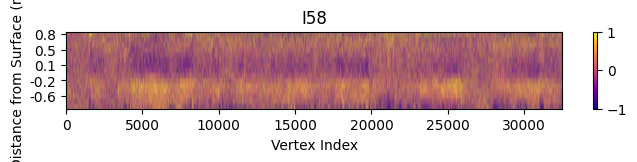

In [5]:
plt.figure(figsize=(8,1))

subject_index = 1
tmp = lh_intensity_data_uncut[subject_index]
print(lh_subject_names[subject_index])
print(f"Shape of tmp: {tmp.shape}")
print(f"First row (index 0) of tmp: {tmp[0, :5]}...")  # Show first 5 values of first row
print(f"Last row (index {tmp.shape[0]-1}) of tmp: {tmp[-1, :5]}...")  # Show first 5 values of last row

# imshow displays the array with:
# - First row (tmp[0, :]) at the TOP of the image (y=0)
# - Last row (tmp[-1, :]) at the BOTTOM of the image
# - Origin is at top-left corner by default
# - Each row in the array becomes a horizontal line in the image
# - Row index increases from top to bottom in the displayed image

#sort by mean of column
#tmp = tmp[:, np.argsort(np.mean(tmp, axis=0))]
plt.imshow(tmp, cmap='plasma', aspect='auto')
plt.colorbar()
plt.title(lh_subject_names[subject_index])
plt.xlabel('Vertex Index')

# Calculate rolling average of consecutive pairs for y-axis labels
dist_array_avg = []
for i in range(len(dist_array) - 1):
    avg = (dist_array[i] + dist_array[i + 1]) / 2
    dist_array_avg.append(avg)
dist_array_avg = np.array(dist_array_avg)

# Set y-axis ticks and labels using dist_array_avg
y_tick_positions = np.arange(0, len(dist_array_avg), max(1, len(dist_array_avg)//5))
y_tick_labels = [f'{dist_array_avg[i]:.1f}' for i in y_tick_positions]
plt.yticks(y_tick_positions, y_tick_labels)
plt.ylabel('Distance from Surface (mm)')
plt.clim(-1,1)

print(f"\nNote: In imshow, tmp[0, :] (first row) appears at the TOP of the image")
print(f"tmp[{tmp.shape[0]-1}, :] (last row) appears at the BOTTOM of the image")

[ 0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12 -0.24 -0.36 -0.48
 -0.6  -0.72 -0.84]


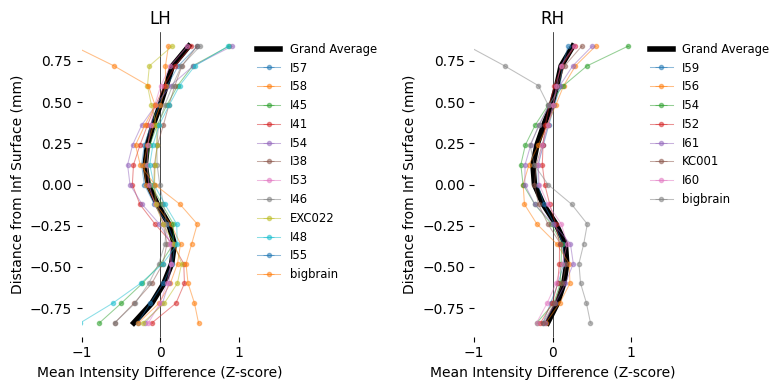

In [6]:
plt.figure(figsize=(8,4))
xlim_max = 1
# Calculate rolling average of consecutive pairs
dist_array_avg = []
for i in range(len(dist_array) - 1):
    avg = (dist_array[i] + dist_array[i + 1]) / 2
    dist_array_avg.append(avg)
dist_array_avg = np.array(dist_array_avg)
print(dist_array_avg)

# Set up y-ticks
y_max = tmp_dat.shape[0]
y_tick_indices = np.arange(0, y_max, 3)  # Every 3rd index

# Plot both hemispheres
for subplot_idx, (hemi, subject_names, subject_data) in enumerate([
    ('lh', lh_subject_names, lh_intensity_data_uncut),
    ('rh', rh_subject_names, rh_intensity_data_uncut)
], 1):
    
    plt.subplot(1, 2, subplot_idx)

    # Plot each subject
    grand_average_intensity = []
    for i, tmp in enumerate(subject_data):
        mean_intensity = np.mean(tmp, axis=1)
        sem_intensity = np.std(tmp, axis=1) / np.sqrt(tmp.shape[1]-1)
        
        plt.errorbar(mean_intensity, dist_array_avg, 
                    xerr=sem_intensity, fmt='-o', linewidth=0.75, 
                    markersize=3, alpha=0.5, label=subject_names[i])
        grand_average_intensity.append(mean_intensity)

    grand_average_intensity = np.nanmean(grand_average_intensity, axis=0)
    plt.plot(grand_average_intensity, dist_array_avg, 'k-', linewidth=4, alpha=1, label='Grand Average', zorder=0)
    

    # 
    mid_line = 0
    #plt.ylim(mid_line-6,mid_line+6)
    plt.xlim(-xlim_max,xlim_max)
    # Add reference lines
    #plt.axhline(y=mid_line, color='black', linestyle='--')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Mean Intensity Difference (Z-score)')
    plt.ylabel('Distance from Inf Surface (mm)')
    plt.title(f'{hemi.upper()[0] + hemi[1:].upper()}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()






In [7]:
print(dist_array_avg)

[ 0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12 -0.24 -0.36 -0.48
 -0.6  -0.72 -0.84]


Data shape: (15, 32492)
Distance array: [ 0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12 -0.24 -0.36 -0.48
 -0.6  -0.72 -0.84]
Zero index: 7
Depths - Zero: 0.000, Up: -0.480, Down: 0.480


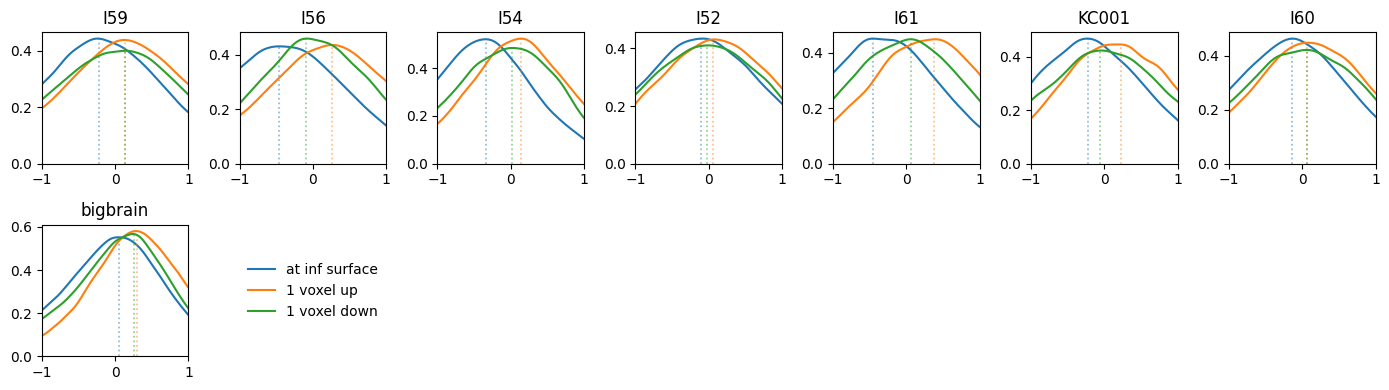


Peak distances for all subjects:
at_inf_surface: [np.float64(-0.22044088176352794), np.float64(-0.460921843687375), np.float64(-0.34068136272545146), np.float64(-0.10020040080160442), np.float64(-0.460921843687375), np.float64(-0.22044088176352794), np.float64(-0.1402805611222444), np.float64(0.060120240480960874)]
  Mean: -0.235, Std: 0.169
1_voxel_up: [np.float64(0.1402805611222444), np.float64(0.26052104208416793), np.float64(0.1402805611222444), np.float64(0.060120240480960874), np.float64(0.38076152304609145), np.float64(0.22044088176352616), np.float64(0.060120240480960874), np.float64(0.3006012024048097)]
  Mean: 0.195, Std: 0.108
1_voxel_down: [np.float64(0.1402805611222444), np.float64(-0.10020040080160442), np.float64(0.020040080160320883), np.float64(-0.020040080160320883), np.float64(0.060120240480960874), np.float64(-0.06012024048096265), np.float64(0.060120240480960874), np.float64(0.26052104208416793)]
  Mean: 0.045, Std: 0.108
[np.float64(-0.22044088176352794), np.floa

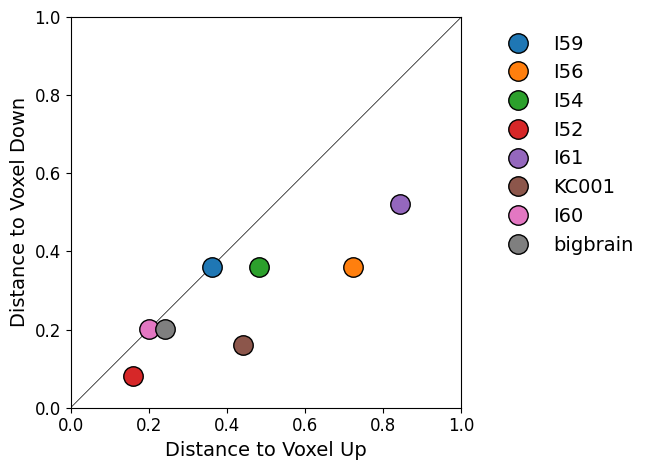

In [8]:
# Analyze intensity data at specific depth positions
print(f"Data shape: {subject_data[0].shape}")
print(f"Distance array: {dist_array_avg}")

# Find key depth positions
zero_index = np.where(dist_array_avg == 0)[0][0]
one_voxel_up = zero_index + 4
one_voxel_down = zero_index - 4

print(f"Zero index: {zero_index}")
print(f"Depths - Zero: {dist_array_avg[zero_index]:.3f}, Up: {dist_array_avg[one_voxel_up]:.3f}, Down: {dist_array_avg[one_voxel_down]:.3f}")

# Plot KDE distributions for each subject

hemi = 'rh'
subject_data = lh_intensity_data_uncut if hemi == 'lh' else rh_intensity_data_uncut
subject_names = lh_subject_names if hemi == 'lh' else rh_subject_names
n_subjects = len(subject_data)
fig, axes = plt.subplots(2, 7, figsize=(14, 4))
axes = axes.flatten()

x_range = np.linspace(-10, 10, 500)

# Storage for peak distances for later analysis
peak_distances_all_subjects = {
    'at_inf_surface': [],
    '1_voxel_up': [],
    '1_voxel_down': []
}

for i, tmp in enumerate(subject_data):
    ax = axes[i]
    
    # Remove NaN values
    tmp = np.where(~np.isnan(tmp), tmp, 0)
    
    # Calculate KDE for three depth positions
    positions = [
        (zero_index, 'at inf surface', 'at_inf_surface'),
        (one_voxel_up, '1 voxel up', '1_voxel_up'),
        (one_voxel_down, '1 voxel down', '1_voxel_down')
    ]
    
    for pos_idx, label, key in positions:
        kde = gaussian_kde(tmp[pos_idx, :])
        kde_vals = kde(x_range)
        line = ax.plot(x_range, kde_vals, alpha=1, linewidth=1.5, label=label)
        
        # Add peak indicator and store peak distance
        peak_idx = np.argmax(kde_vals)
        peak_x, peak_y = x_range[peak_idx], kde_vals[peak_idx]
        ax.plot([peak_x, peak_x], [0, peak_y], ':', alpha=0.5, linewidth=1.25, color=line[0].get_color())
        
        # Store peak distance for later analysis
        peak_distances_all_subjects[key].append(peak_x)
    
    # Format subplot
    ax.set_xlim(-1, 1)
    ax.set_ylim(bottom=0)
    ax.set_title(f'{subject_names[i]}')

# Add legend to the next available subplot position
if n_subjects < len(axes):
    legend_ax = axes[n_subjects]
    legend_ax.axis('off')  # Hide the axes
    # Create dummy plots for legend
    for pos_idx, label, key in positions:
        legend_ax.plot([], [], alpha=1, linewidth=1.5, label=label)
    legend_ax.legend(loc='center', frameon=False)

# Hide remaining empty subplots
for j in range(n_subjects + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Print stored peak distances for verification
print("\nPeak distances for all subjects:")
for key, values in peak_distances_all_subjects.items():
    print(f"{key}: {values}")
    print(f"  Mean: {np.mean(values):.3f}, Std: {np.std(values):.3f}")



print(peak_distances_all_subjects['at_inf_surface'])
print(peak_distances_all_subjects['1_voxel_up'])
print(peak_distances_all_subjects['1_voxel_down'])
# Convert lists to numpy arrays for element-wise operations
at_inf_surface = np.array(peak_distances_all_subjects['at_inf_surface'])
voxel_up = np.array(peak_distances_all_subjects['1_voxel_up'])
voxel_down = np.array(peak_distances_all_subjects['1_voxel_down'])

# Create a colormap with more distinguished colors for each subject
# Using a combination of different colormaps to ensure maximum distinction
n_subjects = len(subject_names)
if n_subjects <= 10:
    colors = plt.cm.tab10(np.arange(n_subjects))
else:
    # For more than 10 subjects, combine multiple colormaps
    colors1 = plt.cm.tab10(np.arange(10))
    colors2 = plt.cm.Set3(np.arange(n_subjects - 10))
    colors = np.vstack([colors1, colors2])

for i, subject_name in enumerate(subject_names):
    plt.plot(abs(voxel_up[i]-at_inf_surface[i]), abs(voxel_down[i]-at_inf_surface[i]), 'o', 
             color=colors[i], label=subject_name, markersize=14, markeredgecolor='black')
plt.legend(subject_names, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=14)
#make the axis equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Distance to Voxel Up', fontsize=14)
plt.ylabel('Distance to Voxel Down', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
#plot x=y line
plt.plot([0, 1], [0, 1], 'k-', linewidth=0.5, zorder=0)
plt.xlim(0,1)
plt.ylim(0,1)
plt.tight_layout()
plt.show()



In [9]:
from scipy.stats import zscore

#do analysis separate for lh and rh
lh_intensity_data = [];
rh_intensity_data = [];
lh_label_data = [];
rh_label_data = [];
lh_subject_names = [];
rh_subject_names = [];
layer = 'inf'
data_type = "diff"
use_normalized_data =False
do_diff = True
clim_max = 1
spacing_mm = 0.24#make it the same as the data
base_path_intensity = "/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_240um_max_480um_dist_method1"
postfix = base_path_intensity.split('_')[-5]

print(postfix)
for subjects in os.listdir(base_path):
    #for now skip I54_confidence
    if subjects == 'I54_new_confidence':
        continue
    if subjects:
        for hemispheres in ['lh','rh']:
            intensity_file_path = os.path.join(base_path_intensity, subjects, f"{hemispheres}/intensity_{data_type}_{postfix}_results.npz")

            if os.path.exists(intensity_file_path):
                # Load intensity data
                data = np.load(intensity_file_path, allow_pickle=True)
                params = data['params']
                dist_array = params.item()['dist_array']
                min_dist = np.min(dist_array)
                max_dist = np.max(dist_array)
                '''
                if data_type == 'diff':
                    #at 0.06 is where the zero should be* I checked with local file
                    at_zero = np.where(dist_array == 0.06)[0][0]#this is where the zero should be at for diff dtta
                else:
                    at_zero = np.where(dist_array == 0.06)[0][0]# 
                '''
                #grab the last postivie value before negative
                #the first index is removed from getting the zero because we are calculating differences
                if data_type == 'diff':
                    zero_indices = np.where(dist_array[1:] == 0)[0]
                else:
                #for non-distance, this should be correct
                    zero_indices = np.where(dist_array == 0)[0]

                if len(zero_indices) > 0:
                    at_zero = zero_indices[0]
                else:
                    at_zero = np.where(dist_array > 0)[0][-1]
                print(at_zero)
                #
                #ap_order = data['inf_ap_order']
                ## Sort data by anterior-posterior order
                #surface_order = np.argsort(ap_order)
                
                

                if use_normalized_data:
                    tmp_dat = data[f'{layer}_{data_type}_norm_intensity'];
                else:   
                    tmp_dat = data[f'{layer}_{data_type}_intensity'];
   
            
                #sort by column intensity
                #intensity_tmp_data = tmp_dat[:, np.argsort(tmp_dat[at_zero,:])]
                 #intensity_tmp_data = intensity_tmp_data[at_zero-num_rows:at_zero+num_rows+1, :]
               

                print(tmp_dat.shape)
                #order data by mean intensity along column
                intensity_tmp_data = tmp_dat[:,np.argsort(np.mean(tmp_dat,axis=0))]
                #intensity_tmp_data = intensity_tmp_data[at_zero-num_rows:at_zero+num_rows+1, :]
              
                
                if hemispheres == 'lh':
                    lh_intensity_data.append(intensity_tmp_data)
                    lh_subject_names.append(subjects.replace('_new_confidence',''))
                else:
                    rh_intensity_data.append(intensity_tmp_data)
                    rh_subject_names.append(subjects.replace('_new_confidence',''))

rh_intensity_data = np.array(rh_intensity_data) 
lh_intensity_data = np.array(lh_intensity_data)
rh_label_data = np.array(rh_label_data)
lh_label_data = np.array(lh_label_data)

## plot start

x_label_title = 'Vertices (unordered)'
layer_type = 'inf'

y_extent = [min_dist,max_dist]
cmap = 'RdBu_r'

# Create figure with subplots
hemi = 'lh'
data = rh_intensity_data if hemi == 'rh' else lh_intensity_data
subject_names = rh_subject_names if hemi == 'rh' else lh_subject_names
n_subjects = len(data)

cols = min(5, n_subjects)  # Max 5 columns
rows = (n_subjects + cols - 1) // cols  # Calculate required rows

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*2))
if n_subjects == 1:
    axes = [axes]
elif rows == 1:
    axes = axes.reshape(1, -1)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Keep track of the last image for colorbar
im = None

for idx, le_data in enumerate(data):
    ax = axes_flat[idx]
  #  le_data = zscore(le_data,axis=0)
    im = ax.imshow(le_data, aspect='auto', cmap=cmap, 
                  extent=[0, le_data.shape[1], y_extent[0], y_extent[1]])
    
    # Configure clim
    im.set_clim(-clim_max, clim_max)
    
    # Configure axes
    y_ticks_pos = np.arange(0, y_extent[1], spacing_mm*2)
    y_ticks_neg = np.arange(0, y_extent[0], -spacing_mm*2)[1:]
    y_ticks = np.concatenate([y_ticks_neg, y_ticks_pos])
    
    ax.set_yticks(y_ticks)
    ax.set_ylabel(f'Rel. {layer_type} surface (mm)',fontsize = 7)
    ax.set_xlabel(x_label_title)
    ax.set_ylim(min_dist,max_dist)
   # ax.set_ylim(-num_rows*spacing_mm ,num_rows*spacing_mm)
   # ax.axhline(y=0, color='black', linewidth=0.5, linestyle=':')
    
    # Add subject title
    ax.set_title(f'Subject {subject_names[idx]}')

    # Add direction labels
    ax2 = ax.twinx()
    ax2.set_ylim(y_extent)
    ax2.set_yticks([spacing_mm*10, spacing_mm*len(le_data)*4])
    ax2.set_yticklabels(['neg norm', 'pos norm'], rotation=-90, fontsize=7)
    ax2.get_yticklabels()[0].set_color('#2166AC')
    ax2.get_yticklabels()[1].set_color('#B2182B')


# Hide unused subplots
for idx in range(n_subjects, len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=2.0)

# Add a single colorbar for all subplots after tight_layout
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, aspect=20)
if do_diff:
    if use_normalized_data:
        cbar.set_label('Intensity difference (z-score)', fontsize=12, rotation=270, labelpad=15)
    else:
        cbar.set_label('Intensity difference', fontsize=12, rotation=270, labelpad=15)
else:
    if use_normalized_data:
        cbar.set_label('Intensity (z-score)', fontsize=12, rotation=270, labelpad=15)
    else:
        cbar.set_label('Intensity', fontsize=12, rotation=270, labelpad=15)

cbar.set_ticks([-clim_max, 0, clim_max])
cbar.ax.set_yticklabels([f'<-{clim_max}', '0', f'>{clim_max}'])
print(dist_array)


240um


NameError: name 'min_dist' is not defined

In [ ]:
#do analysis separate for lh and rh
lh_intensity_data_at_zero = [];
rh_intensity_data_at_zero = [];
lh_intensity_data_at_plus_036 = []# 3 ticks since the spacing is 0.12mm
rh_intensity_data_at_plus_036 = []
lh_intensity_data_at_minus_036 = []
rh_intensity_data_at_minus_036 = []
lh_label_data = [];
rh_label_data = [];
lh_subject_names = [];
rh_subject_names = [];
layer = 'white'
data_type = "diff"

parcel_type = "baillarger" #or "baillarger"
base_path_intensity = "/Users/dennis.jungchildmind.org/Desktop/exvivo_figures_norm_120um"
for subjects in os.listdir(base_path):
    #for now skip I54_confidence
    if subjects == 'I54_new_confidence':
        continue
    if subjects:
        for hemispheres in ['lh','rh']:
            label_file_path = os.path.join(base_path, subjects, niu_folder, f"{subjects}_{hemispheres}_{parcel_type}_parcellation.label.gii")
            intensity_file_path = os.path.join(base_path_intensity, subjects, f"{hemispheres}/intensity_norm_{data_type}_results.npz")

            if os.path.exists(label_file_path):
                print(label_file_path)
                label_tmp = nib.load(label_file_path).darrays[0].data
                print(label_tmp)
                # Load intensity data
                data = np.load(intensity_file_path, allow_pickle=True)
                params = data['params']
                dist_array = params.item()['dist_array']

                if data_type == 'diff':
                    #at 0.06 is where the zero should be* I checked with local file
                    at_zero = np.where(dist_array == 0.06)[0][0]#this is where the zero should be at for diff dtta
                else:
                    at_zero = np.where(dist_array == 0.06)[0][0]# 

                print('zero value at:',at_zero)
                ap_order = data['inf_ap_order']
                # Sort data by anterior-posterior order
                surface_order = np.argsort(ap_order)

                #difference away
                num_ticks_away_from_surface = 1
                intensity_tmp_data = data[f'{layer}_{data_type}_intensity'][at_zero, surface_order]
                intensity_tmp_data_at_plus_036 = data[f'{layer}_{data_type}_intensity'][at_zero+num_ticks_away_from_surface, surface_order]
                intensity_tmp_data_at_minus_036 = data[f'{layer}_{data_type}_intensity'][at_zero-num_ticks_away_from_surface, surface_order]

                
                if hemispheres == 'lh':
                    lh_label_data.append(label_tmp)
                    lh_intensity_data_at_zero.append(intensity_tmp_data)
                    lh_intensity_data_at_plus_036.append(intensity_tmp_data_at_plus_036)
                    lh_intensity_data_at_minus_036.append(intensity_tmp_data_at_minus_036)
                    lh_subject_names.append(subjects.replace('_new_confidence',''))
                else:
                    rh_label_data.append(label_tmp)
                    rh_intensity_data_at_zero.append(intensity_tmp_data)
                    rh_intensity_data_at_plus_036.append(intensity_tmp_data_at_plus_036)
                    rh_intensity_data_at_minus_036.append(intensity_tmp_data_at_minus_036)
                    rh_subject_names.append(subjects.replace('_new_confidence',''))

rh_intensity_data_at_zero = np.array(rh_intensity_data_at_zero) 
lh_intensity_data_at_zero = np.array(lh_intensity_data_at_zero)
rh_intensity_data_at_plus_036 = np.array(rh_intensity_data_at_plus_036)
lh_intensity_data_at_plus_036 = np.array(lh_intensity_data_at_plus_036)
rh_intensity_data_at_minus_036 = np.array(rh_intensity_data_at_minus_036)
lh_intensity_data_at_minus_036 = np.array(lh_intensity_data_at_minus_036)
rh_label_data = np.array(rh_label_data)
lh_label_data = np.array(lh_label_data)

In [ ]:
from scipy.stats import gaussian_kde
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

index = 0
kde = gaussian_kde(lh_intensity_data_at_zero[index])
x_range = np.linspace(-10,10, 500)
plt.plot(x_range, kde(x_range), alpha=0.5, linewidth=0.5, marker='s', label='at inf surface')
kde_plus_036 = gaussian_kde(lh_intensity_data_at_plus_036[index])
x_range = np.linspace(-10,10, 500)
plt.plot(x_range, kde_plus_036(x_range), alpha=0.5, linewidth=1, marker='o', label='at -0.36mm') #pluse036 is negative **
kde_minus_036 = gaussian_kde(lh_intensity_data_at_minus_036[index])
x_range = np.linspace(-10,10, 500)
plt.plot(x_range, kde_minus_036(x_range), alpha=0.5, linewidth=1, marker='^', label='at 0.36mm')
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference ')
plt.ylabel('Density')
subject_name = lh_subject_names[0]
plt.title(subject_name)

In [ ]:
#okay now do for every subjects in lh
hemi = 'rh'

if hemi == 'lh':
    num_subjects = len(lh_intensity_data_at_zero)
elif hemi == 'rh':
    num_subjects = len(rh_intensity_data_at_zero)
cols = 5
rows = (num_subjects + cols - 1) // cols  # Calculate rows needed

plt.figure(figsize=(15, 3 * rows))

for i in range(num_subjects):
    plt.subplot(rows, cols, i + 1)
    if hemi == 'lh':
        kde = gaussian_kde(lh_intensity_data_at_zero[i])
    elif hemi == 'rh':
        kde = gaussian_kde(rh_intensity_data_at_zero[i])

    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde(x_range), alpha=0.5, linewidth=0.5, marker='s', label='at inf surface')
    kde_plus_036 = gaussian_kde(lh_intensity_data_at_plus_036[i])
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde_plus_036(x_range), alpha=0.5, linewidth=1, marker='o', label='at -0.36mm') #pluse036 is negative **
    kde_minus_036 = gaussian_kde(lh_intensity_data_at_minus_036[i])
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde_minus_036(x_range), alpha=0.5, linewidth=1, marker='^', label='at 0.36mm')
    if i == 0:  # Only show legend for the first plot
        plt.legend()
    plt.xlim(-5,5)
    plt.xlabel('Intensity difference ')
    plt.ylabel('Density')
    if hemi == 'lh':
        subject_name = lh_subject_names[i]
    elif hemi == 'rh':
        subject_name = rh_subject_names[i]
    plt.title(subject_name)

plt.tight_layout()


In [ ]:
from scipy.stats import gaussian_kde
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i,tmp in enumerate(lh_intensity_data_at_zero):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=lh_subject_names[i])
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference ')
plt.ylabel('Density')

plt.subplot(1,2,2)
for i,tmp in enumerate(rh_intensity_data_at_zero):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=rh_subject_names[i])
    
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')


In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i,tmp in enumerate(lh_intensity_data):
    plt.hist(tmp, bins=500, alpha=0.3, label=lh_subject_names[i], density=True)
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')

plt.subplot(1,2,2)
for i,tmp in enumerate(rh_intensity_data):
    plt.hist(tmp, bins=500, alpha=0.3, label=rh_subject_names[i], density=True)
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')


from scipy.stats import gaussian_kde
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i,tmp in enumerate(lh_intensity_data):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-5, 5, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=lh_subject_names[i])
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference ')
plt.ylabel('Density')

plt.subplot(1,2,2)
for i,tmp in enumerate(rh_intensity_data):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-5, 5, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=rh_subject_names[i])
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')


In [ ]:
spacing_mm = 0.24
dist_max_mm = 0.48  
tmp = np.flipud(np.concatenate([-np.arange(spacing_mm, dist_max_mm + spacing_mm, spacing_mm)[::-1], [0], 
                                            np.arange(spacing_mm, dist_max_mm + spacing_mm, spacing_mm)]))
print(tmp)

In [ ]:
#resulting in 214 regions (64 frontal, 60 parietal, 63 temporal, 21 occipital, and 6 insular)
#find the
clim_rng = [-1,1]
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(lh_intensity_data, aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
plt.xlabel('Vertices (unordered)')
#plt.yticks(range(len(lh_intensity_data)), range(1, len(lh_intensity_data) + 1))
#set yticks to be subject names 
plt.yticks(range(len(lh_intensity_data)), lh_subject_names)

plt.subplot(2,2,2)
plt.imshow(rh_intensity_data, aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
plt.xlabel('Vertices (unordered)')
#plt.yticks(range(len(rh_intensity_data)), range(1, len(rh_intensity_data) + 1))
#set yticks to be subject names 
plt.yticks(range(len(rh_intensity_data)), rh_subject_names)
sorting_index = np.argsort(rh_label_data[0,:])
find_bndries = np.where(np.diff(rh_label_data[0,sorting_index]) != 0)[0]

plt.subplot(2,2,3)  
plt.imshow(lh_intensity_data[:,sorting_index], aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
plt.xlabel('Vertices (ordered based on Baillarger type)')
#plt.yticks(range(len(lh_intensity_data)), range(1, len(lh_intensity_data) + 1))
#set yticks to be subject names
plt.yticks(range(len(lh_intensity_data)), lh_subject_names)
#draw vertical liens
for i in find_bndries:
    plt.axvline(i, color='k', linestyle='--')

sorting_index = np.argsort(lh_label_data[0,:])
find_bndries = np.where(np.diff(lh_label_data[0,sorting_index]) != 0)[0]
plt.subplot(2,2,4)
plt.imshow(rh_intensity_data[:,sorting_index], aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
#set yticks to be subject names
plt.yticks(range(len(rh_intensity_data)), rh_subject_names)
plt.xlabel('Vertices (ordered based on Baillarger type)')
#plt.yticks(range(len(rh_intensity_data)), range(1, len(rh_intensity_data) + 1))
#draw vertical liens
vert_line_names = ['']
for i in find_bndries:
    plt.axvline(i, color='k', linestyle='--')
    #for 


In [ ]:
#load von